<img src="logo-catedra.png" width="400"> <img src="Logo-GIIATa-small.png" width="100"> 
<div style="text-align: right"> _Por: V. Robles B._ </div>

# Entornos de soporte al desarrollo de simulaciones: Simpy - Parte 1

## 1. Instalación de Simpy
Existen diversas alternativas para instalar **simpy** (no confundir con _sympy_), sin embargo, en esta subsección mostraremos cómo hacerlo a través de la creación de un entorno virtual.

### 1.1. Prerrequisitos:
Debemos contar con los siguientes paquetes previamente instalados:
* Anaconda [Guía de instalación de Anaconda](https://www.digitalocean.com/community/tutorials/how-to-install-the-anaconda-python-distribution-on-ubuntu-16-04)
* Jupyter Notebook [Guía de instalación](http://jupyter.readthedocs.io/en/latest/install.html) (Si se desea poder abrir los cuadernos con ejemplos de simulación con **simpy**).

### 1.2. Pasos a seguir:
En virtud de que **simpy** requiere la versión 3.4 de Python, llevaremos a cabo el proceso para instalar dicha versión:
1. Creamos el entorno virtual llamado "simulacion" con la versión 3.4 de Python:

        conda create --name simulacion python=3.4
        
2. Installamos **simpy**  en el entorno creado:
        conda install --name simulacion simpy

3. Activamos el entorno vitual "simulacion" e instalamos **ipykernel** para poder seleccionar el **kernel** de python con el que trabajaremos (en los cuadernos de Jupyter Notebook):

        source activate simulacion
        pip install ipykernel
        python -m ipykernel install --user --name simulacion --display-name "python 3.4-simulacion"
        
4. Una vez que hemos arrancado el servidor de Jupyter (con el comando _jupyter notebook_) y tenemos un cuaderno abierto, podemos escoger con qué **kernel** trabajar, como se indica en la siguietne figura:

<img src="Cambiar-Kernel.png">

Si la instalación ha sido exitosa, podremos ejecutar el siguiente código sin inconvenientes:

In [1]:
import simpy

# Definimos un reloj:
def reloj(env, nombre, tiempo):
    while True:
        print(nombre,">",env.now) 
        yield env.timeout(tiempo) # Pasamos el control al programa principal
        
env=simpy.Environment() # Creamos un entorno de simulación
env.process(reloj(env, 'R. Rapido',0.235)) # Ejecutamos un "reloj" rapido (timer) en el entorno con el tiempo especificado
env.process(reloj(env, 'R. Lento',0.47)) # Ejecutamos un "reloj" lento (timer) en el entorno con el tiempo especificado

env.run(until=2) # Ejecutamos los procesos 2 unidades de tiempo

R. Rapido > 0
R. Lento > 0
R. Rapido > 0.235
R. Lento > 0.47
R. Rapido > 0.47
R. Rapido > 0.705
R. Lento > 0.94
R. Rapido > 0.94
R. Rapido > 1.1749999999999998
R. Rapido > 1.4099999999999997
R. Lento > 1.41
R. Rapido > 1.6449999999999996
R. Rapido > 1.8799999999999994
R. Lento > 1.88


## 2. Ejemplo del negocio de lavado de autos [5]

Este ejemplo permite simular un negocio de lavado de automóviles. De igual forma, es importante destacar que este ejemplo aborda los siguientes puntos:

* Estados de espera por otros procesos
* Recursos: clase **Resource**


### 2.1. Características del sistema real a simular

Es importante observar que el negocio de lavado de autos tiene características propias a su naturaleza. A continuación establecemos dichas peculiaridades a tener en mente en el momento de llevar a cabo la simulación:

* El negocio tiene un número limitado de máquinas de lavado.
* Se puede recibir un cierto número de vehículos para ser lavados, de los cuáles los que no estén siendo procesados tendrán que esperar.
* Una vez que un vehículo entra a la máquina, debe ser lavado y solo al finalizar la limpieza podrá salir de la misma, dejando un espacio libre a otro vehículo.

### 2.2. Desarrollo de la simulación

A continuación procedemos a desarrollar la simulación.

Como primer paso, importamos las librerías necesarias y establecemos los parámetros requeridos:
* Variables de interés
* Tiempo de simulación
* Parámetros de inicialización (número de máquinas, tiempo de lavado, intervalo de llegada de vehículos).

In [7]:
import simpy
import random

# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57 
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 3
# Tiempo que tarda en lavarse un vehiculo (minutos)
TIEMPO_LAVADO = 7 
# Intervalo de tiempo en que llegan vehiculos (minutos)
INTERVALO_LLEGADA = 9
# Tiempo de simulación
TIEMPO_SIMULACION = 23

class Lavanderia(object):
    
    def __init__(self, environment, num_maquinas, tiempo_lavado):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_lavado = tiempo_lavado
        
    def lavar_vehiculo(self, vehiculo):
        # Este metodo representa el proceso de lavado del vehículo.
        # Se ingresa el vehículo y se lava
        
        # Simulamos el tiempo que tarda en lavarse el vehiculo
        # Es importante notar que la instruccion "yield" es distinta de "sleep"
        # ya que esta ultima bloquea el hilo de ejecucion durante 't' unidades de tiempo,
        # mientras que 'yield' no bloquea el hilo de ejecucion, solo lo suspende mientras
        # el evento de 'lavado' se realice
        yield self.env.timeout(TIEMPO_LAVADO)
        
        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        print('Removido  {%d%%} suciedad vehiculo => %s ' \
              % (random.randint(30,90), vehiculo))
        
    
def llegada_vehiculo(env, nombre, lavanderia):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehiculo: %s a la hora %.2f.' % (nombre, env.now))
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    with lavanderia.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina
        # Indicamos que vehiculo entra a la lavanderia
        print('Entra vehiculo a lavarse: %s a la hora %.2f.' % (nombre, env.now))
        # Procesamos la operacion de lavado
        yield env.process(lavanderia.lavar_vehiculo(nombre))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] lavado a las %.2f.' % (nombre, env.now))
    
    
def ejecutar_simulacion(env, num_maquinas, tiempo_lavado, intervalo):
    lavanderia=Lavanderia(env, num_maquinas, tiempo_lavado)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(5):
        env.process(llegada_vehiculo(env, 'Vehiculo-%d'%(i+1),lavanderia))
    
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-2, intervalo+2))
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
        env.process(llegada_vehiculo(env,'Vehiculo-%d'%(i+1),lavanderia))

print('Lavanderia UPS')
# Inicializamos la semilla aleatoria
random.seed(77)

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MAQUINAS, TIEMPO_LAVADO, INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)


Lavanderia UPS
Llega vehiculo: Vehiculo-1 a la hora 0.00.
Llega vehiculo: Vehiculo-2 a la hora 0.00.
Llega vehiculo: Vehiculo-3 a la hora 0.00.
Llega vehiculo: Vehiculo-4 a la hora 0.00.
Llega vehiculo: Vehiculo-5 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-1 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-2 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-3 a la hora 0.00.
Removido  {50%} suciedad vehiculo => Vehiculo-1 
Removido  {42%} suciedad vehiculo => Vehiculo-2 
Removido  {45%} suciedad vehiculo => Vehiculo-3 
Vehiculo [Vehiculo-1] lavado a las 7.00.
Vehiculo [Vehiculo-2] lavado a las 7.00.
Vehiculo [Vehiculo-3] lavado a las 7.00.
Entra vehiculo a lavarse: Vehiculo-4 a la hora 7.00.
Entra vehiculo a lavarse: Vehiculo-5 a la hora 7.00.
Llega vehiculo: Vehiculo-6 a la hora 9.00.
Entra vehiculo a lavarse: Vehiculo-6 a la hora 9.00.
Removido  {82%} suciedad vehiculo => Vehiculo-4 
Removido  {90%} suciedad vehiculo => Vehiculo-5 
Vehiculo [Vehiculo-4] lavado a las 14.00.

### 2.3. Visualizando la información de la simulación

A continuación modificaremos el ejemplo propuesto en el libro guía de SimPy a fin de incluir una gráfica que nos provea información sobre la simulación realizada


Lavanderia UPS
Llega vehiculo: Vehiculo-1 a la hora 0.00.
Llega vehiculo: Vehiculo-2 a la hora 0.00.
Llega vehiculo: Vehiculo-3 a la hora 0.00.
Llega vehiculo: Vehiculo-4 a la hora 0.00.
Llega vehiculo: Vehiculo-5 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-1 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-2 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-3 a la hora 0.00.
Removido  {46%} suciedad vehiculo => Vehiculo-1 
Removido  {50%} suciedad vehiculo => Vehiculo-2 
Removido  {42%} suciedad vehiculo => Vehiculo-3 
Vehiculo [Vehiculo-1] lavado a las 7.00.
Vehiculo [Vehiculo-2] lavado a las 7.00.
Vehiculo [Vehiculo-3] lavado a las 7.00.
Entra vehiculo a lavarse: Vehiculo-4 a la hora 7.00.
Entra vehiculo a lavarse: Vehiculo-5 a la hora 7.00.
Llega vehiculo: Vehiculo-6 a la hora 12.00.
Entra vehiculo a lavarse: Vehiculo-6 a la hora 12.00.
Removido  {42%} suciedad vehiculo => Vehiculo-4 
Removido  {82%} suciedad vehiculo => Vehiculo-5 
Vehiculo [Vehiculo-4] lavado a las 14.0

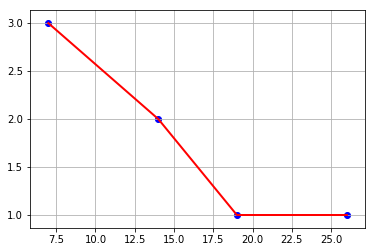

In [8]:
import simpy
import random
import matplotlib.pyplot as pp

%matplotlib inline

# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57 
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 3
# Tiempo que tarda en lavarse un vehiculo (minutos)
TIEMPO_LAVADO = 7 
# Intervalo de tiempo en que llegan vehiculos (minutos)
INTERVALO_LLEGADA = 9
# Tiempo de simulación
TIEMPO_SIMULACION = 27

# Creamos un diccionario para almacenar las horas en que se lavan los vehiculos
tiempo={}

class Lavanderia(object):
    
    def __init__(self, environment, num_maquinas, tiempo_lavado):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_lavado = tiempo_lavado
        
    def lavar_vehiculo(self, vehiculo):
        # Este metodo representa el proceso de lavado del vehículo.
        # Se ingresa el vehículo y se lava
        
        # Simulamos el tiempo que tarda en lavarse el vehiculo
        # Es importante notar que la instruccion "yield" es distinta de "sleep"
        # ya que esta ultima bloquea el hilo de ejecucion durante 't' unidades de tiempo,
        # mientras que 'yield' no bloquea el hilo de ejecucion, solo lo suspende mientras
        # el evento de 'lavado' se realice
        yield self.env.timeout(TIEMPO_LAVADO)
        
        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        print('Removido  {%d%%} suciedad vehiculo => %s ' % (random.randint(30,90), vehiculo))
        
    
def llegada_vehiculo(env, nombre, lavanderia):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehiculo: %s a la hora %.2f.' % (nombre, env.now))
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    with lavanderia.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina
        # Indicamos que vehiculo entra a la lavanderia
        print('Entra vehiculo a lavarse: %s a la hora %.2f.' % (nombre, env.now))
        # Procesamos la operacion de lavado
        yield env.process(lavanderia.lavar_vehiculo(nombre))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] lavado a las %.2f.' % (nombre, env.now))

        k=env.now
    if k in tiempo:
        tiempo[k]=tiempo[k]+1
    else:
        tiempo[k]=1
    
    
    
def ejecutar_simulacion(env, num_maquinas, tiempo_lavado, intervalo):
    lavanderia=Lavanderia(env, num_maquinas, tiempo_lavado)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(5):
        env.process(llegada_vehiculo(env, 'Vehiculo-%d'%(i+1),lavanderia))
    
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-3, intervalo+3))
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
        env.process(llegada_vehiculo(env,'Vehiculo-%d'%(i+1),lavanderia))

print('Lavanderia UPS')
# Inicializamos la semilla aleatoria
random.seed(77)

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MAQUINAS, TIEMPO_LAVADO, INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

# Generamos la grafica
datos=sorted(tiempo.items())
x, y =zip(*datos)
pp.plot(x,y,linewidth=2,color='red')
pp.scatter(x,y,color='blue')
pp.grid(True)
pp.show()

## Práctica 1 - SimPy SED

Modifique el código anterior a fin de incorporar los siguientes cambios:

* Considerar 3 tipos de vehículos con 3 diferentes tiempos de lavado:
    * Bus: 20 minutos
    * Automóvil: 7 minutos
    * Furgoneta: 12 minutos
* Considere que a partir de la entrada del vehículo para ser lavado, deberán tomarse en cuenta los siguientes tiempos correspondientes al proceso de traslado desde la recepción a la máquina de lavado:
    * Bus: 4 minutos
    * Automóvil: 1 minuto
    * Furgoneta: 2 minutos
* Realice una gráfica comparativa de la simulación con 3 y con 4 máquinas de lavado


## Referencias
[1] Matloff, N. (2008). Introduction to Discrete-Event Simulation and the SimPy Language.

[2] Team Simpy (2017). SimPy Documentation, Release 3.0.10, 2017. URL: https://media.readthedocs.org/pdf/simpy/latest/simpy.pdf 